In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
start_time = time.time()
from google.colab import drive
drive.mount('/content/drive')
S = np.load('/content/drive/My Drive/Toric Code 18 qubits/Nonlocal/S50.npy')
SS = np.array([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
               [-1, +1, -1, -1, -1, -1, -1, +1, -1, -1, -1, -1, -1, +1, -1, -1, -1, -1],
               [-1, -1, -1, -1, -1, -1, -1, -1, -1, +1, +1, +1, -1, -1, -1, -1, -1, -1],
               [-1, +1, -1, -1, -1, -1, -1, +1, -1, +1, +1, +1, -1, +1, -1, -1, -1, -1]])

# Translational symmetry, Real variables.
(ss, tt, lam, N) = (0.01, 100, 1.0, len(S))
BF = torch.tensor([0.0])
WF = torch.tensor([np.pi/4, np.pi/4, np.pi/4, np.pi/4])
BV = torch.tensor([0.1], requires_grad=True)
WV = torch.tensor([1.5, 1.55, 1.6, 1.65], requires_grad=True)
# Global phase is added to rotate
Global = -np.pi/2
# Phase stores the complex phases added at Bl position
Phase = torch.tensor([-0.5, -0.2, 0.9, -0.2, 0.0, 0.2], requires_grad=True)
GL = torch.tensor([np.pi/4, np.pi/4, np.pi/2])
BL = torch.tensor([np.pi/4, np.pi/4, 0.0])
WL = torch.tensor([np.pi/4, np.pi/4, np.pi/4])
AL = torch.tensor([np.pi/4, np.pi/4, np.pi/4])
optimizer = torch.optim.Adam([BV, WV, Phase], lr=ss)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# pr and prr are the shortcut for cosh functions.
def pr(b, w, s1, s2, s3, s4):
    result = torch.cosh(b[0] + 1j * (w[0] * s1 + w[1] * s2 + w[2] * s3 + w[3] * s4))
    return result
def prr(b, b1, b2, w, s1, s2, s3):
    result = torch.cosh(1j * b + (b1 + b2 * 1j) + 1j * w * (s1 + s2 + s3))
    return result
def prrr(b, b1, b2, w, s1, s2, s3, s4, s5, s6):
    result = torch.cosh(1j * b + (b1 + b2 * 1j) + 1j * w * (s1 + s2 + s3 + s4 + s5 + s6))
    return result


# ph is the phase function.
def ph(bl, phase, wl, al, bv, wv, bf, wf, s):
    result = (np.exp(1j * Global) * np.exp(1j * GL[0]) * np.exp(1j * GL[1]) * np.exp(1j * GL[2])
              * torch.exp(1j * al[0] * (s[0]+s[1]+s[2])) * torch.exp(1j * al[1] * (s[3]+s[9]+s[15]))
              * torch.exp(1j * al[2] * (s[0]+s[1]+s[2]+s[3]+s[9]+s[15]))
              * prr(bl[0], phase[0], phase[3], wl[0], s[0], s[1], s[2])
              * prr(bl[1], phase[1], phase[4], wl[1], s[3], s[9], s[15])
              * prrr(bl[2], phase[2], phase[5], wl[2], s[0], s[1], s[2], s[3], s[9], s[15])
              * pr(bv, wv, s[0], s[3], s[2], s[15]) * pr(bv, wv, s[1], s[4], s[0], s[16])
              * pr(bv, wv, s[2], s[5], s[1], s[17]) * pr(bv, wv, s[6], s[9], s[8], s[3])
              * pr(bv, wv, s[7], s[10], s[6], s[4]) * pr(bv, wv, s[8], s[11], s[7], s[5])
              * pr(bv, wv, s[12], s[15], s[14], s[9]) * pr(bv, wv, s[13], s[16], s[12], s[10])
              * pr(bv, wv, s[14], s[17], s[13], s[11]) * pr(bf, wf, s[4], s[6], s[3], s[0])
              * pr(bf, wf, s[5], s[7], s[4], s[1]) * pr(bf, wf, s[3], s[8], s[5], s[2])
              * pr(bf, wf, s[10], s[12], s[9], s[6]) * pr(bf, wf, s[11], s[13], s[10], s[7])
              * pr(bf, wf, s[9], s[14], s[11], s[8]) * pr(bf, wf, s[16], s[0], s[15], s[12])
              * pr(bf, wf, s[17], s[1], s[16], s[13]) * pr(bf, wf, s[15], s[2], s[17], s[14]))
    return result


# nor is the normalize function.
def nor(bl, phase, wl, al, bv, wv, bf, wf):
    result = 0
    for i in range(len(S)):
      result += abs(ph(bl, phase, wl, al, bv, wv, bf, wf, S[i]))
    return result


# The 9 vertex operators flip qubits.
A1 = np.diag([-1, +1, -1, -1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1, +1])
A2 = np.diag([-1, -1, +1, +1, -1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1])
A3 = np.diag([+1, -1, -1, +1, +1, -1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1])
A4 = np.diag([+1, +1, +1, -1, +1, +1, -1, +1, -1, -1, +1, +1, +1, +1, +1, +1, +1, +1])
A5 = np.diag([+1, +1, +1, +1, -1, +1, -1, -1, +1, +1, -1, +1, +1, +1, +1, +1, +1, +1])
A6 = np.diag([+1, +1, +1, +1, +1, -1, +1, -1, -1, +1, +1, -1, +1, +1, +1, +1, +1, +1])
A7 = np.diag([+1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1, +1, -1, +1, -1, -1, +1, +1])
A8 = np.diag([+1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1, -1, -1, +1, +1, -1, +1])
A9 = np.diag([+1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1, -1, -1, +1, +1, -1])
S1 = np.dot(S, A1)
S2 = np.dot(S, A2)
S3 = np.dot(S, A3)
S4 = np.dot(S, A4)
S5 = np.dot(S, A5)
S6 = np.dot(S, A6)
S7 = np.dot(S, A7)
S8 = np.dot(S, A8)
S9 = np.dot(S, A9)

# lam is the multiplier to amplify the choice of ground state
def criterion(bl, phase, wl, al, bv, wv, bf, wf):
    V = torch.empty((18*N+3,), dtype=torch.complex64)
    for k in range(N):
        sub = ph(bl, phase, wl, al, bv, wv, bf, wf, S[k])
        one = ph(bl, phase, wl, al, bv, wv, bf, wf, SS[0])
        V[k] = ph(bl, phase, wl, al, bv, wv, bf, wf, S1[k]) - sub
        V[1*N+k] = ph(bl, phase, wl, al, bv, wv, bf, wf, S2[k]) - sub
        V[2*N+k] = ph(bl, phase, wl, al, bv, wv, bf, wf, S3[k]) - sub
        V[3*N+k] = ph(bl, phase, wl, al, bv, wv, bf, wf, S4[k]) - sub
        V[4*N+k] = ph(bl, phase, wl, al, bv, wv, bf, wf, S5[k]) - sub
        V[5*N+k] = ph(bl, phase, wl, al, bv, wv, bf, wf, S6[k]) - sub
        V[6*N+k] = ph(bl, phase, wl, al, bv, wv, bf, wf, S7[k]) - sub
        V[7*N+k] = ph(bl, phase, wl, al, bv, wv, bf, wf, S8[k]) - sub
        V[8*N+k] = ph(bl, phase, wl, al, bv, wv, bf, wf, S9[k]) - sub
        V[9*N+k] = (S[k][4]*S[k][6]*S[k][3]*S[k][0]-1) * sub
        V[10*N+k] = (S[k][5]*S[k][7]*S[k][4]*S[k][1]-1) * sub
        V[11*N+k] = (S[k][3]*S[k][8]*S[k][5]*S[k][2]-1) * sub
        V[12*N+k] = (S[k][10]*S[k][12]*S[k][9]*S[k][6]-1) * sub
        V[13*N+k] = (S[k][11]*S[k][13]*S[k][10]*S[k][7]-1) * sub
        V[14*N+k] = (S[k][9]*S[k][14]*S[k][11]*S[k][8]-1) * sub
        V[15*N+k] = (S[k][16]*S[k][0]*S[k][15]*S[k][12]-1) * sub
        V[16*N+k] = (S[k][17]*S[k][1]*S[k][16]*S[k][13]-1) * sub
        V[17*N+k] = (S[k][15]*S[k][2]*S[k][17]*S[k][14]-1) * sub
        V[18*N+0] = lam * (ph(bl, phase, wl, al, bv, wv, bf, wf, SS[1])-2*one)
        V[18*N+1] = lam * (ph(bl, phase, wl, al, bv, wv, bf, wf, SS[2])-3*one)
        V[18*N+2] = lam * (ph(bl, phase, wl, al, bv, wv, bf, wf, SS[3])-4*one)
    v = torch.norm(V)/nor(bl, phase, wl, al, bv, wv, bf, wf)
    return v

In [ ]:
# Stochastic gradient descent
COST = []
ABV = []
AWV = [[], [], [], []]
APhase = [[], [], [], [], [], []]
for h in range(tt):
    cost = criterion(BL, Phase, WL, AL, BV, WV, BF, WF)
    COST.append(cost.tolist())
    ABV.append(BV[0].tolist())
    for p in range(4):
        AWV[p].append(WV[p].tolist())
    for q in range(6):
        APhase[q].append(Phase[q].tolist())
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 536.0947580337524 seconds


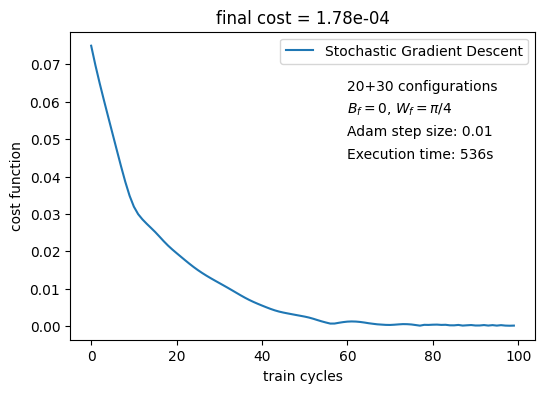

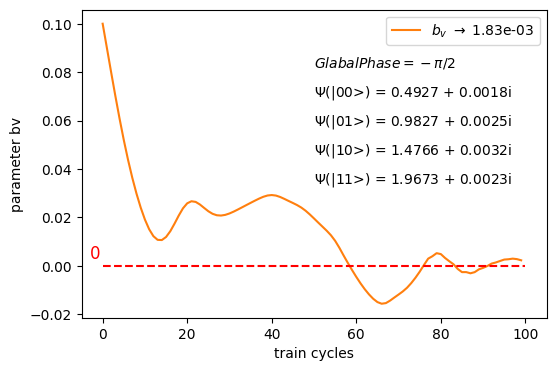

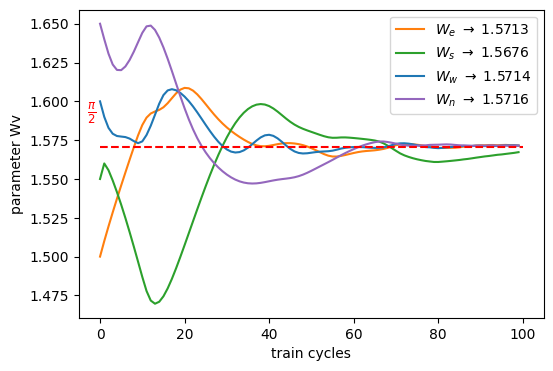

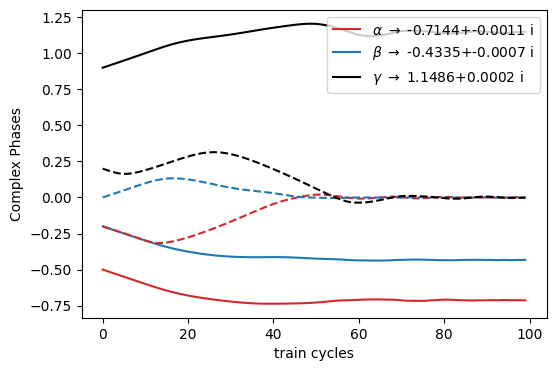

In [ ]:
# Visualize results: Cost
Final = cost.data.item()
fig1 = plt.figure(figsize=(6, 4))
plt.plot(COST, label="Stochastic Gradient Descent")
plt.title("final cost = %.2e" % Final)
plt.text(0.6 * tt, 0.84 * COST[0], "20+30 configurations")
plt.text(0.6 * tt, 0.76 * COST[0], "$B_{f} = 0$, $W_{f} = \pi/4$")
plt.text(0.6 * tt, 0.68 * COST[0], "Adam step size: %.2f" % ss)
plt.text(0.6 * tt, 0.6 * COST[0], "Execution time: %is" % execution_time)
plt.xlabel("train cycles")
plt.ylabel("cost function")
plt.legend()
plt.show()

# Visualize results: BV
fig2 = plt.figure(figsize=(6, 4))
plt.plot(ABV, color='tab:orange', label=r"$b_v$ $\rightarrow$ %.2e" % BV[0].data.item())
plt.plot([0, tt], [0.0, 0.0], 'r--', linewidth=1.5)
plt.text(-0.03 * tt, 0.003, '0', color='r', fontsize=12)
plt.text(0.5 * tt, 0.82 * ABV[0], "$Glabal Phase = -\pi/2$")
plt.text(0.5 * tt, 0.70 * ABV[0], "$\Psi$(|00>) = %.4f + %.4fi" % (
    ph(BL, Phase, WL, AL, BV, WV, BF, WF, SS[0]).data.item().real, ph(BL, Phase, WL, AL, BV, WV, BF, WF, SS[0]).data.item().imag))
plt.text(0.5 * tt, 0.58 * ABV[0], "$\Psi$(|01>) = %.4f + %.4fi" % (
    ph(BL, Phase, WL, AL, BV, WV, BF, WF, SS[1]).data.item().real, ph(BL, Phase, WL, AL, BV, WV, BF, WF, SS[1]).data.item().imag))
plt.text(0.5 * tt, 0.46 * ABV[0], "$\Psi$(|10>) = %.4f + %.4fi" % (
    ph(BL, Phase, WL, AL, BV, WV, BF, WF, SS[2]).data.item().real, ph(BL, Phase, WL, AL, BV, WV, BF, WF, SS[2]).data.item().imag))
plt.text(0.5 * tt, 0.34 * ABV[0], "$\Psi$(|11>) = %.4f + %.4fi" % (
    ph(BL, Phase, WL, AL, BV, WV, BF, WF, SS[3]).data.item().real, ph(BL, Phase, WL, AL, BV, WV, BF, WF, SS[3]).data.item().imag))
plt.xlabel("train cycles")
plt.ylabel("parameter bv")
plt.legend()
plt.show()

# Visualize results: WV
fig2 = plt.figure(figsize=(6, 4))
plt.plot(AWV[0], color='tab:orange', label=r"$W_e$ $\rightarrow$ %.4f" % WV[0].data.item())
plt.plot(AWV[1], color='tab:green', label=r"$W_s$ $\rightarrow$ %.4f" % WV[1].data.item())
plt.plot(AWV[2], color='tab:blue', label=r"$W_w$ $\rightarrow$ %.4f" % WV[2].data.item())
plt.plot(AWV[3], color='tab:purple', label=r"$W_n$ $\rightarrow$ %.4f" % WV[3].data.item())
plt.plot([0, tt], [1.5708, 1.5708], 'r--', linewidth=1.5)
plt.text(-0.03 * tt, 1.59, r'$\frac{\pi}{2}$', color='r', fontsize=12)
plt.xlabel("train cycles")
plt.ylabel("parameter Wv")
plt.legend()
plt.show()

# Visualize results: Complex Phases
fig3 = plt.figure(figsize=(6, 4))
plt.plot(APhase[0], color='tab:red', label=r"$\alpha$ $\rightarrow$ %.4f+%.4f i" % (Phase[0].data.item(),Phase[3].data.item()))
plt.plot(APhase[1], color='tab:blue', label=r"$\beta$ $\rightarrow$ %.4f+%.4f i" % (Phase[1].data.item(),Phase[4].data.item()))
plt.plot(APhase[2], color='black', label=r"$\gamma$ $\rightarrow$ %.4f+%.4f i" % (Phase[2].data.item(),Phase[5].data.item()))
plt.plot(APhase[3], '--', color='tab:red')
plt.plot(APhase[4], '--', color='tab:blue')
plt.plot(APhase[5], '--', color='black')
plt.xlabel("train cycles")
plt.ylabel("Complex Phases")
plt.legend()
plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
start_time = time.time()
from google.colab import drive
drive.mount('/content/drive')
S = np.load('/content/drive/My Drive/Toric Code 18 qubits/Nonlocal/S50.npy')
SS = np.array([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
               [-1, +1, -1, -1, -1, -1, -1, +1, -1, -1, -1, -1, -1, +1, -1, -1, -1, -1],
               [-1, -1, -1, -1, -1, -1, -1, -1, -1, +1, +1, +1, -1, -1, -1, -1, -1, -1],
               [-1, +1, -1, -1, -1, -1, -1, +1, -1, +1, +1, +1, -1, +1, -1, -1, -1, -1]])

# Translational symmetry, Real variables.
(ss, tt, lam, N) = (0.01, 500, 1.0, len(S))
BF = torch.tensor([0.0])
WF = torch.tensor([np.pi/4, np.pi/4, np.pi/4, np.pi/4])
BV = torch.tensor([0.1], requires_grad=True)
WV = torch.tensor([1.4, 1.5, 1.6, 1.7], requires_grad=True)
# Global phase is added to rotate
Global = -np.pi/2
# Phase stores the complex phases added at Bl position
Phase = torch.tensor([-0.4, -0.1, 0.8, -0.2, 0.1, 0.4], requires_grad=True)
GL = torch.tensor([np.pi/4, np.pi/4, np.pi/2])
BL = torch.tensor([np.pi/4, np.pi/4, 0.0])
WL = torch.tensor([np.pi/4, np.pi/4, np.pi/4])
AL = torch.tensor([np.pi/4, np.pi/4, np.pi/4])
optimizer = torch.optim.Adam([BV, WV, Phase], lr=ss)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# pr and prr are the shortcut for cosh functions.
def pr(b, w, s1, s2, s3, s4):
    result = torch.cosh(b[0] + 1j * (w[0] * s1 + w[1] * s2 + w[2] * s3 + w[3] * s4))
    return result
def prr(b, b1, b2, w, s1, s2, s3):
    result = torch.cosh(1j * b + (b1 + b2 * 1j) + 1j * w * (s1 + s2 + s3))
    return result
def prrr(b, b1, b2, w, s1, s2, s3, s4, s5, s6):
    result = torch.cosh(1j * b + (b1 + b2 * 1j) + 1j * w * (s1 + s2 + s3 + s4 + s5 + s6))
    return result


# ph is the phase function.
def ph(bl, phase, wl, al, bv, wv, bf, wf, s):
    result = (np.exp(1j * Global) * np.exp(1j * GL[0]) * np.exp(1j * GL[1]) * np.exp(1j * GL[2])
              * torch.exp(1j * al[0] * (s[0]+s[1]+s[2])) * torch.exp(1j * al[1] * (s[3]+s[9]+s[15]))
              * torch.exp(1j * al[2] * (s[0]+s[1]+s[2]+s[3]+s[9]+s[15]))
              * prr(bl[0], phase[0], phase[3], wl[0], s[0], s[1], s[2])
              * prr(bl[1], phase[1], phase[4], wl[1], s[3], s[9], s[15])
              * prrr(bl[2], phase[2], phase[5], wl[2], s[0], s[1], s[2], s[3], s[9], s[15])
              * pr(bv, wv, s[0], s[3], s[2], s[15]) * pr(bv, wv, s[1], s[4], s[0], s[16])
              * pr(bv, wv, s[2], s[5], s[1], s[17]) * pr(bv, wv, s[6], s[9], s[8], s[3])
              * pr(bv, wv, s[7], s[10], s[6], s[4]) * pr(bv, wv, s[8], s[11], s[7], s[5])
              * pr(bv, wv, s[12], s[15], s[14], s[9]) * pr(bv, wv, s[13], s[16], s[12], s[10])
              * pr(bv, wv, s[14], s[17], s[13], s[11]) * pr(bf, wf, s[4], s[6], s[3], s[0])
              * pr(bf, wf, s[5], s[7], s[4], s[1]) * pr(bf, wf, s[3], s[8], s[5], s[2])
              * pr(bf, wf, s[10], s[12], s[9], s[6]) * pr(bf, wf, s[11], s[13], s[10], s[7])
              * pr(bf, wf, s[9], s[14], s[11], s[8]) * pr(bf, wf, s[16], s[0], s[15], s[12])
              * pr(bf, wf, s[17], s[1], s[16], s[13]) * pr(bf, wf, s[15], s[2], s[17], s[14]))
    return result


# nor is the normalize function.
def nor(bl, phase, wl, al, bv, wv, bf, wf):
    result = 0
    for i in range(len(S)):
      result += abs(ph(bl, phase, wl, al, bv, wv, bf, wf, S[i]))
    return result


# The 9 vertex operators flip qubits.
A1 = np.diag([-1, +1, -1, -1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1, +1])
A2 = np.diag([-1, -1, +1, +1, -1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1])
A3 = np.diag([+1, -1, -1, +1, +1, -1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1])
A4 = np.diag([+1, +1, +1, -1, +1, +1, -1, +1, -1, -1, +1, +1, +1, +1, +1, +1, +1, +1])
A5 = np.diag([+1, +1, +1, +1, -1, +1, -1, -1, +1, +1, -1, +1, +1, +1, +1, +1, +1, +1])
A6 = np.diag([+1, +1, +1, +1, +1, -1, +1, -1, -1, +1, +1, -1, +1, +1, +1, +1, +1, +1])
A7 = np.diag([+1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1, +1, -1, +1, -1, -1, +1, +1])
A8 = np.diag([+1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1, -1, -1, +1, +1, -1, +1])
A9 = np.diag([+1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1, -1, -1, +1, +1, -1])
S1 = np.dot(S, A1)
S2 = np.dot(S, A2)
S3 = np.dot(S, A3)
S4 = np.dot(S, A4)
S5 = np.dot(S, A5)
S6 = np.dot(S, A6)
S7 = np.dot(S, A7)
S8 = np.dot(S, A8)
S9 = np.dot(S, A9)

# lam is the multiplier to amplify the choice of ground state
def criterion(bl, phase, wl, al, bv, wv, bf, wf):
    V = torch.empty((18*N+3,), dtype=torch.complex64)
    for k in range(N):
        sub = ph(bl, phase, wl, al, bv, wv, bf, wf, S[k])
        one = ph(bl, phase, wl, al, bv, wv, bf, wf, SS[0])
        V[k] = ph(bl, phase, wl, al, bv, wv, bf, wf, S1[k]) - sub
        V[1*N+k] = ph(bl, phase, wl, al, bv, wv, bf, wf, S2[k]) - sub
        V[2*N+k] = ph(bl, phase, wl, al, bv, wv, bf, wf, S3[k]) - sub
        V[3*N+k] = ph(bl, phase, wl, al, bv, wv, bf, wf, S4[k]) - sub
        V[4*N+k] = ph(bl, phase, wl, al, bv, wv, bf, wf, S5[k]) - sub
        V[5*N+k] = ph(bl, phase, wl, al, bv, wv, bf, wf, S6[k]) - sub
        V[6*N+k] = ph(bl, phase, wl, al, bv, wv, bf, wf, S7[k]) - sub
        V[7*N+k] = ph(bl, phase, wl, al, bv, wv, bf, wf, S8[k]) - sub
        V[8*N+k] = ph(bl, phase, wl, al, bv, wv, bf, wf, S9[k]) - sub
        V[9*N+k] = (S[k][4]*S[k][6]*S[k][3]*S[k][0]-1) * sub
        V[10*N+k] = (S[k][5]*S[k][7]*S[k][4]*S[k][1]-1) * sub
        V[11*N+k] = (S[k][3]*S[k][8]*S[k][5]*S[k][2]-1) * sub
        V[12*N+k] = (S[k][10]*S[k][12]*S[k][9]*S[k][6]-1) * sub
        V[13*N+k] = (S[k][11]*S[k][13]*S[k][10]*S[k][7]-1) * sub
        V[14*N+k] = (S[k][9]*S[k][14]*S[k][11]*S[k][8]-1) * sub
        V[15*N+k] = (S[k][16]*S[k][0]*S[k][15]*S[k][12]-1) * sub
        V[16*N+k] = (S[k][17]*S[k][1]*S[k][16]*S[k][13]-1) * sub
        V[17*N+k] = (S[k][15]*S[k][2]*S[k][17]*S[k][14]-1) * sub
        V[18*N+0] = lam * (ph(bl, phase, wl, al, bv, wv, bf, wf, SS[1])-2*one)
        V[18*N+1] = lam * (ph(bl, phase, wl, al, bv, wv, bf, wf, SS[2])-3*one)
        V[18*N+2] = lam * (ph(bl, phase, wl, al, bv, wv, bf, wf, SS[3])-4*one)
    v = torch.norm(V)/nor(bl, phase, wl, al, bv, wv, bf, wf)
    return v

In [ ]:
# Stochastic gradient descent
COST = []
ABV = []
AWV = [[], [], [], []]
APhase = [[], [], [], [], [], []]
for h in range(tt):
    cost = criterion(BL, Phase, WL, AL, BV, WV, BF, WF)
    COST.append(cost.tolist())
    ABV.append(BV[0].tolist())
    for p in range(4):
        AWV[p].append(WV[p].tolist())
    for q in range(6):
        APhase[q].append(Phase[q].tolist())
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 2468.346433877945 seconds


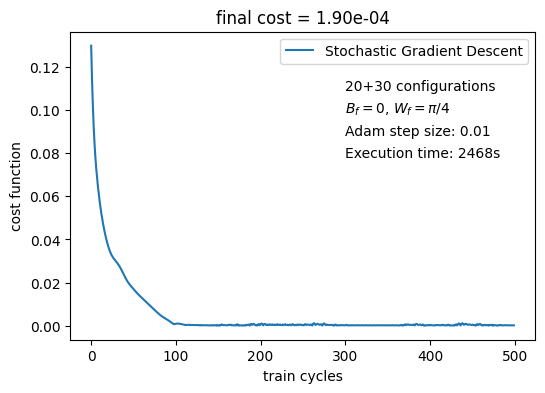

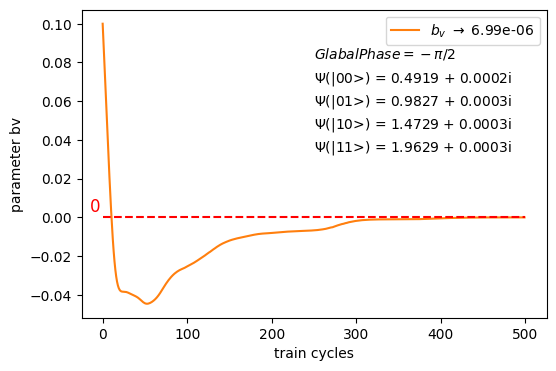

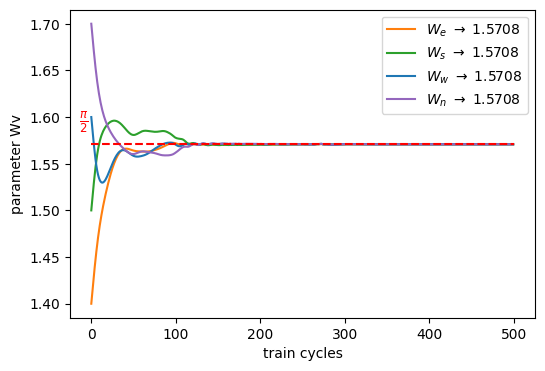

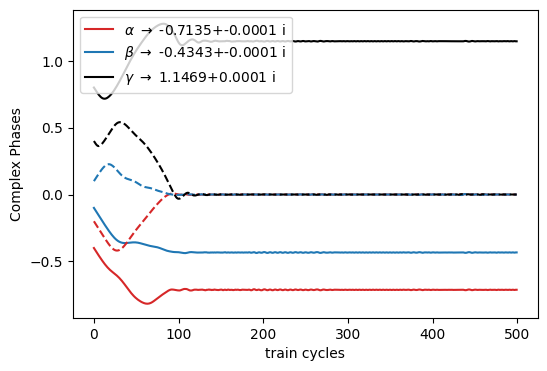

In [ ]:
# Visualize results: Cost
Final = cost.data.item()
fig1 = plt.figure(figsize=(6, 4))
plt.plot(COST, label="Stochastic Gradient Descent")
plt.title("final cost = %.2e" % Final)
plt.text(0.6 * tt, 0.84 * COST[0], "20+30 configurations")
plt.text(0.6 * tt, 0.76 * COST[0], "$B_{f} = 0$, $W_{f} = \pi/4$")
plt.text(0.6 * tt, 0.68 * COST[0], "Adam step size: %.2f" % ss)
plt.text(0.6 * tt, 0.6 * COST[0], "Execution time: %is" % execution_time)
plt.xlabel("train cycles")
plt.ylabel("cost function")
plt.legend()
plt.show()

# Visualize results: BV
fig2 = plt.figure(figsize=(6, 4))
plt.plot(ABV, color='tab:orange', label=r"$b_v$ $\rightarrow$ %.2e" % BV[0].data.item())
plt.plot([0, tt], [0.0, 0.0], 'r--', linewidth=1.5)
plt.text(-0.03 * tt, 0.003, '0', color='r', fontsize=12)
plt.text(0.5 * tt, 0.82 * ABV[0], "$Glabal Phase = -\pi/2$")
plt.text(0.5 * tt, 0.70 * ABV[0], "$\Psi$(|00>) = %.4f + %.4fi" % (
    ph(BL, Phase, WL, AL, BV, WV, BF, WF, SS[0]).data.item().real, ph(BL, Phase, WL, AL, BV, WV, BF, WF, SS[0]).data.item().imag))
plt.text(0.5 * tt, 0.58 * ABV[0], "$\Psi$(|01>) = %.4f + %.4fi" % (
    ph(BL, Phase, WL, AL, BV, WV, BF, WF, SS[1]).data.item().real, ph(BL, Phase, WL, AL, BV, WV, BF, WF, SS[1]).data.item().imag))
plt.text(0.5 * tt, 0.46 * ABV[0], "$\Psi$(|10>) = %.4f + %.4fi" % (
    ph(BL, Phase, WL, AL, BV, WV, BF, WF, SS[2]).data.item().real, ph(BL, Phase, WL, AL, BV, WV, BF, WF, SS[2]).data.item().imag))
plt.text(0.5 * tt, 0.34 * ABV[0], "$\Psi$(|11>) = %.4f + %.4fi" % (
    ph(BL, Phase, WL, AL, BV, WV, BF, WF, SS[3]).data.item().real, ph(BL, Phase, WL, AL, BV, WV, BF, WF, SS[3]).data.item().imag))
plt.xlabel("train cycles")
plt.ylabel("parameter bv")
plt.legend()
plt.show()

# Visualize results: WV
fig2 = plt.figure(figsize=(6, 4))
plt.plot(AWV[0], color='tab:orange', label=r"$W_e$ $\rightarrow$ %.4f" % WV[0].data.item())
plt.plot(AWV[1], color='tab:green', label=r"$W_s$ $\rightarrow$ %.4f" % WV[1].data.item())
plt.plot(AWV[2], color='tab:blue', label=r"$W_w$ $\rightarrow$ %.4f" % WV[2].data.item())
plt.plot(AWV[3], color='tab:purple', label=r"$W_n$ $\rightarrow$ %.4f" % WV[3].data.item())
plt.plot([0, tt], [1.5708, 1.5708], 'r--', linewidth=1.5)
plt.text(-0.03 * tt, 1.59, r'$\frac{\pi}{2}$', color='r', fontsize=12)
plt.xlabel("train cycles")
plt.ylabel("parameter Wv")
plt.legend()
plt.show()

# Visualize results: Complex Phases
fig3 = plt.figure(figsize=(6, 4))
plt.plot(APhase[0], color='tab:red', label=r"$\alpha$ $\rightarrow$ %.4f+%.4f i" % (Phase[0].data.item(),Phase[3].data.item()))
plt.plot(APhase[1], color='tab:blue', label=r"$\beta$ $\rightarrow$ %.4f+%.4f i" % (Phase[1].data.item(),Phase[4].data.item()))
plt.plot(APhase[2], color='black', label=r"$\gamma$ $\rightarrow$ %.4f+%.4f i" % (Phase[2].data.item(),Phase[5].data.item()))
plt.plot(APhase[3], '--', color='tab:red')
plt.plot(APhase[4], '--', color='tab:blue')
plt.plot(APhase[5], '--', color='black')
plt.xlabel("train cycles")
plt.ylabel("Complex Phases")
plt.legend()
plt.show()